# **Density Matrix Renormalization Group**


We employ the density matrix renormalization group (DMRG) algorithm
to optimize a matrix product state (MPS) such that it is the
eigenvector of lowest eigenvalue of a Hermitian matrix H.
The MPS `psi0` is used to initialize the MPS to be optimized,
and the `sweeps` object determines the parameters used to 
control the DMRG algorithm.

This version of `dmrg` accepts a representation of H as a
Vector of MPOs, Hs = [H1,H2,H3,...] such that H is defined
as H = H1+H2+H3+...
Note that this sum of MPOs is not actually computed; rather
the set of MPOs [H1,H2,H3,..] is efficiently looped over at 
each step of the DMRG algorithm when optimizing the MPS.


## Imports

In [ ]:
#import Pkg
#Pkg.add(["ITensors", "IJulia", "Plots", "Random", "ITensorMPS"])

In [9]:
using ITensors, ITensorMPS, Random, Plots

## Example

In [10]:
let
  N = 100
  sites = siteinds("S=1",N)

  os = OpSum()

  # Building Hamiltonian
  for j=1:N-1
    os += "Sz",j,"Sz",j+1
    os += 0.5,"S+",j,"S-",j+1
    os += 0.5,"S-",j,"S+",j+1
  end
  H = MPO(os,sites) # Hamiltonian

  psi0 = random_mps(sites;linkdims=10) # Matrix product state

  nsweeps = 5 # number of DMRG sweeps
  maxdim = [10,20,100,100,200] # max dimensions
  cutoff = [1E-10] # convergence cutoff

  energy,psi = dmrg(H,psi0;nsweeps,maxdim,cutoff) # DMRG optimization

  return
end

After sweep 1 energy=-138.82806024804503  maxlinkdim=10 maxerr=1.49E-02 time=18.255
After sweep 2 energy=-138.93729148353523  maxlinkdim=20 maxerr=4.91E-06 time=0.595
After sweep 3 energy=-138.9400844125599  maxlinkdim=89 maxerr=9.99E-11 time=3.745
After sweep 4 energy=-138.94008605652263  maxlinkdim=99 maxerr=9.99E-11 time=9.743
After sweep 5 energy=-138.940086055616  maxlinkdim=95 maxerr=1.00E-10 time=8.223


The max error reduces signficiantly after the second DMRG sweep

# Heisenberg chain

We will now build the Heisenberg/XXZ chain. We run the DMRG while we log energy as we add sweeps. After that, we amy compare it to known thermodynamic limit ground state energy for $S=1/2$ Heisenberg chain and scan the maximal bond dimension $\chi$.

Now, a known reference (thermodynamic limit, $J=1$) for isotropic Heisenberg chain with $\Delta = 1$ is $e_0 = 1/4 - \ln 2 \approx -0.443$ (energy per site/bond).

In [11]:
# Building Heisenberg MPO with anisotropy

function heisenberg_xxz_mpo(N; delta=1.0)
    sites = siteinds("S=1/2", N)                # S^z eigenvalues ±1/2
    ampo = OpSum()
    for i in 1:N-1                               # open boundary
        ampo += 0.5, "S+", i, "S-", i+1
        ampo += 0.5, "S-", i, "S+", i+1
        ampo += delta,   "Sz", i, "Sz", i+1
    end
    return MPO(ampo, sites), sites
end

heisenberg_xxz_mpo (generic function with 1 method)

In [12]:
# Running DMRG incrementally, we record final energy after n sweeps

function dmrg_sweep_curve(H, sites; χ=128, maxsweeps=8, cutoff=1e-9, seed=42)
    Random.seed!(seed)
    psi = randomMPS(sites; linkdims=min(χ, 10))  # small random start; DMRG ramps up χ
    energies = Float64[]
    for ns = 1:maxsweeps
        sweeps = Sweeps(ns)
        maxdim!(sweeps, fill(χ, ns)...)
        cutoff!(sweeps, fill(cutoff, ns)...)
        # optional: addnoise!(sweeps, 1e-8, 1e-10, 2)  # can help avoid local minima
        E, psi = dmrg(H, psi, sweeps)
        push!(energies, E)
    end
    return energies, psi
end

dmrg_sweep_curve (generic function with 1 method)

In [13]:
# Running DMRG for a list of χ values (fixed # of sweeps each) and return energies.
function dmrg_vs_chi(H, sites; chis=[32, 64, 128, 256], sweeps_per_chi=6, cutoff=1e-9, seed=7)
    Es = Float64[]
    for (k, χ) in enumerate(chis)
        Random.seed!(seed)                       # comparable starts
        psi0 = randomMPS(sites; linkdims=min(χ, 10))
        sweeps = Sweeps(sweeps_per_chi)
        maxdim!(sweeps, fill(χ, sweeps_per_chi)...)
        cutoff!(sweeps, fill(cutoff, sweeps_per_chi)...)
        E, _ = dmrg(H, psi0, sweeps)
        push!(Es, E)
    end
    return Es
end

dmrg_vs_chi (generic function with 1 method)

### Heisenberg ($\Delta=1$), convergence vs. sweeps

After sweep 1 energy=-21.941274084271114  maxlinkdim=39 maxerr=9.95E-10 time=0.302
After sweep 1 energy=-21.971130916631783  maxlinkdim=54 maxerr=9.98E-10 time=0.494
After sweep 2 energy=-21.972106946693987  maxlinkdim=54 maxerr=9.97E-10 time=0.520
After sweep 1 energy=-21.972110146193288  maxlinkdim=52 maxerr=9.96E-10 time=0.544
After sweep 2 energy=-21.97211014050759  maxlinkdim=52 maxerr=9.89E-10 time=0.486
After sweep 3 energy=-21.972110140606063  maxlinkdim=52 maxerr=9.83E-10 time=0.477
After sweep 1 energy=-21.97211014060313  maxlinkdim=52 maxerr=9.83E-10 time=0.512
After sweep 2 energy=-21.972110140603665  maxlinkdim=52 maxerr=9.83E-10 time=0.508
After sweep 3 energy=-21.97211014060877  maxlinkdim=52 maxerr=9.83E-10 time=0.465
After sweep 4 energy=-21.972110140611342  maxlinkdim=52 maxerr=9.83E-10 time=0.491
After sweep 1 energy=-21.972110140611658  maxlinkdim=52 maxerr=9.83E-10 time=0.526
After sweep 2 energy=-21.972110140610397  maxlinkdim=52 maxerr=9.83E-10 time=0.481
After s

-0.4484104110327199

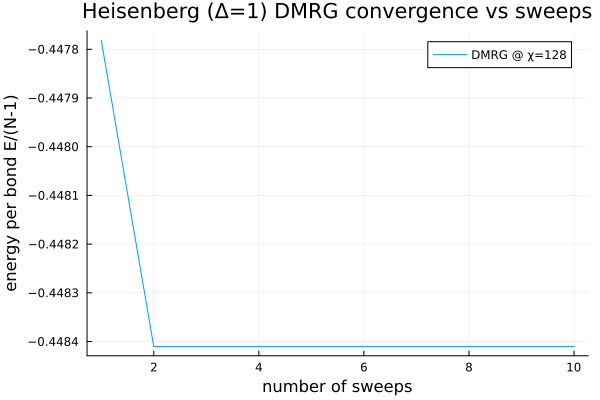

In [14]:
N  = 50                     
Δ  = 1.0
χ  = 128
maxsweeps = 10

H, sites = heisenberg_xxz_mpo(N; delta=Δ)
E_after_nsweeps, psi = dmrg_sweep_curve(H, sites; χ=χ, maxsweeps=maxsweeps, cutoff=1e-9)

e0 = 0.25 - log(2) # Bethe ansatz 
Epb = E_after_nsweeps ./ (N-1)

display(Epb[end])
println("Final per-bond energy: ", Epb[end], "   (reference e0 = ", e0, ")")

plot(1:maxsweeps, Epb; xlabel="number of sweeps",ylabel="energy per bond E/(N-1)",label="DMRG @ χ=$(χ)", title="Heisenberg (Δ=1) DMRG convergence vs sweeps")


In [15]:
println("Bethe ansatz per-bond energy: ", e0)

Bethe ansatz per-bond energy: -0.4431471805599453
